In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fullevents = pd.read_csv("fullevents.csv")
passingevents = pd.read_csv("passingevents.csv")
matches = pd.read_csv("matches.csv")
#将坐标统一！
def convert_coor(row):
    if row[1].startswith('Opponent'):
        for i in range(1,5):
            row[-i] = 100-row[-i]
    return row
def convert_goal_keeper(row):
    if row[6] != 'Pass':
        if str(row[2])[:-1].endswith('G'):
            row[-3] = 50
            if row[1].startswith('Opponent'):
                row[-4] = 100
        elif str(row[3])[:-1].endswith('G'):
            row[-1] = 50
            if row[1].startswith('Opponent'):
                row[-2] = 100
    return row
def add_time_2H(row):
    if row['MatchPeriod'] == '2H':
        row['EventTime'] = row['EventTime']+time_offest[row['MatchID']-1]
    return row
fullevents = fullevents.apply(func=convert_coor,axis=1)
fullevents = fullevents.apply(func=convert_goal_keeper,axis=1)
fullevents.loc[fullevents.EventSubType=='Goal kick', 'EventOrigin_y'] = 50
passingevents = passingevents.apply(func=convert_coor,axis=1)
time_offest = []
for i in range(1,39):
    time_offest.append(passingevents[(passingevents.MatchID==i)&(passingevents.MatchPeriod=='1H')]['EventTime'].iloc[-1])
fullevents = fullevents.apply(func=add_time_2H, axis=1)
passingevents = passingevents.apply(func=add_time_2H, axis=1)

In [2]:
#观察数据
fullevents[fullevents["EventType"]=="Duel"]["EventSubType"].unique()

array(['Air duel', 'Ground loose ball duel', 'Ground defending duel',
       'Ground attacking duel'], dtype=object)

In [3]:
fullevents.shape[0]

59271

In [4]:
fullevents.head()

,MatchID,TeamID,OriginPlayerID,DestinationPlayerID,MatchPeriod,EventTime,EventType,EventSubType,EventOrigin_x,EventOrigin_y,EventDestination_x,EventDestination_y
0,1,Huskies,Huskies_G1,NaN,1H,31.174681,Free Kick,Goal kick,0.0,0.0,66.0,89.0
1,1,Opponent1,Opponent1_D1,NaN,1H,33.730326,Duel,Air duel,34.0,11.0,22.0,0.0
2,1,Huskies,Huskies_F1,NaN,1H,33.812965,Duel,Air duel,66.0,89.0,78.0,100.0
3,1,Opponent1,Opponent1_D2,NaN,1H,42.611028,Free Kick,Throw in,22.0,0.0,66.0,3.0
4,1,Huskies,Huskies_D1,Huskies_F1,1H,46.323501,Pass,Head pass,34.0,97.0,59.0,95.0


In [19]:
#标记成功的Duel(1)和失败的Duel(0)和其他的状态(-1)
dataWithDuel=fullevents.copy()
i=0
status=[] #标记成功的Duel(1)和失败的Duel(0)和其他的状态(-1)
while i<dataWithDuel.shape[0]:
    #是duel的情况
    if dataWithDuel["EventType"][i]=="Duel":
        if dataWithDuel["EventType"][i+1]=="Duel":
            status.append(dataWithDuel["TeamID"][i]==dataWithDuel["TeamID"][i+2])
            status.append(dataWithDuel["TeamID"][i+1]==dataWithDuel["TeamID"][i+2])
            i=i+2
        else:
            status.append(dataWithDuel["TeamID"][i]==dataWithDuel["TeamID"][i+1])
            i=i+1
    else:
        i+=1 
        status.append(-1)  #说明不是争抢(Duel)的情况
status=np.array(status).astype(int)
dataWithDuel["DuelStatus"]=status

In [20]:
pd.isnull(dataWithDuel["DestinationPlayerID"][4])

False

In [21]:
#继续添加传球成功的数据,1为成功，0为不成功
dataWithDuelPass=dataWithDuel.copy()

i=0
status=[] #标记成功的Pass(1)和失败的Pass(0)和其他不是Pass的状态(-1)
while i<dataWithDuelPass.shape[0]:
    #是duel的情况
    if dataWithDuelPass["EventType"][i]=="Pass":
        if pd.isnull(dataWithDuelPass["DestinationPlayerID"][i])==True:
            status.append(0)
        else:
            status.append(1)
    else:
        status.append(-1)  #说明不是争抢(Duel)的情况
    i+=1
# status=np.array(status).astype(int)
dataWithDuelPass["PassStatus"]=status

In [22]:
#DuelStatus和PassStatus都是-1不是该类数据，0失败，1成功
dataWithDuelPass.head(10)

,MatchID,TeamID,OriginPlayerID,DestinationPlayerID,MatchPeriod,EventTime,EventType,EventSubType,EventOrigin_x,EventOrigin_y,EventDestination_x,EventDestination_y,DuelStatus,PassStatus
0,1,Huskies,Huskies_G1,NaN,1H,31.174681,Free Kick,Goal kick,0.0,50.0,66.0,89.0,-1,-1
1,1,Opponent1,Opponent1_D1,NaN,1H,33.730326,Duel,Air duel,66.0,89.0,78.0,100.0,1,-1
2,1,Huskies,Huskies_F1,NaN,1H,33.812965,Duel,Air duel,66.0,89.0,78.0,100.0,0,-1
3,1,Opponent1,Opponent1_D2,NaN,1H,42.611028,Free Kick,Throw in,78.0,100.0,34.0,97.0,-1,-1
4,1,Huskies,Huskies_D1,Huskies_F1,1H,46.323501,Pass,Head pass,34.0,97.0,59.0,95.0,-1,1
5,1,Huskies,Huskies_F1,NaN,1H,47.004714,Duel,Ground loose ball duel,59.0,95.0,64.0,94.0,0,-1
6,1,Opponent1,Opponent1_D1,NaN,1H,47.213716,Duel,Ground loose ball duel,59.0,95.0,64.0,94.0,1,-1
7,1,Opponent1,Opponent1_M1,NaN,1H,48.487897,Pass,Simple pass,64.0,94.0,55.0,95.0,-1,0
8,1,Huskies,Huskies_F1,NaN,1H,49.880983,Pass,Head pass,55.0,95.0,57.0,93.0,-1,0
9,1,Opponent1,Opponent1_D1,NaN,1H,50.109404,Duel,Ground loose ball duel,57.0,93.0,53.0,89.0,0,-1


In [23]:
#再给dataWithDuelPass加上最后一列用于记录比赛发生了多久
def toMinute(seconds):
    return np.floor(seconds/60)+1

dataWithDuelPassTime=dataWithDuelPass.copy()
dataWithDuelPassTime["Time"]=dataWithDuelPassTime["EventTime"].apply(toMinute)

In [24]:
dataWithDuelPassTime.head()

,MatchID,TeamID,OriginPlayerID,DestinationPlayerID,MatchPeriod,EventTime,EventType,EventSubType,EventOrigin_x,EventOrigin_y,EventDestination_x,EventDestination_y,DuelStatus,PassStatus,Time
0,1,Huskies,Huskies_G1,NaN,1H,31.174681,Free Kick,Goal kick,0.0,50.0,66.0,89.0,-1,-1,1.0
1,1,Opponent1,Opponent1_D1,NaN,1H,33.730326,Duel,Air duel,66.0,89.0,78.0,100.0,1,-1,1.0
2,1,Huskies,Huskies_F1,NaN,1H,33.812965,Duel,Air duel,66.0,89.0,78.0,100.0,0,-1,1.0
3,1,Opponent1,Opponent1_D2,NaN,1H,42.611028,Free Kick,Throw in,78.0,100.0,34.0,97.0,-1,-1,1.0
4,1,Huskies,Huskies_D1,Huskies_F1,1H,46.323501,Pass,Head pass,34.0,97.0,59.0,95.0,-1,1,1.0


### 至此，数据处理已经完成，下面开始设计统计的函数

In [11]:
#自动判断要找的target在哪一个类别，EventType还是EventSubType，还是DuelStatus,PassStatus.
def targetJudge(target):
    category=0 #目标的类别
    eventType=['Free Kick', 'Duel', 'Pass', 'Others on the ball', 'Foul','Goalkeeper leaving line', 'Offside', 'Save attempt', 'Shot','Substitution', 'Interruption']
    eventSubType=['Goal kick', 'Air duel', 'Throw in', 'Head pass','Ground loose ball duel', 'Simple pass', 'Launch', 'High pass','Touch', 'Ground defending duel', 'Hand pass','Ground attacking duel', 'Foul', 'Free kick cross','Goalkeeper leaving line', 'Free Kick', 'Smart pass', 'Cross','Save attempt', 'Corner', 'Clearance', 'Shot', 'Acceleration','Reflexes', 'Substitution', 'Late card foul', 'Simulation','Free kick shot', 'Protest', 'Hand foul', 'Penalty','Violent Foul', 'Whistle', 'Out of game foul','Ball out of the field', 'Time lost foul']
    if(target in eventType):
        category=1
        print("Looking for EventType : ",target)
    elif(target in eventSubType):
        category=2
        print("Looking for EventSubType : ",target)
    elif(target == "DuelStatus" or target == "PassStatus"):
        print("Looking for : ",target)
        category=3
    else:
        print("Not found!")
    return category

In [65]:
#target="Pass"这种,只需要统计次数，没有成功、不成功状态的量
def census(data,matches,huskies,target,period,unit=1):
    if period is None:
        period = (1,200)
    if huskies:
        temp=data[(data.MatchID.isin(matches))&(data.TeamID=='Huskies')&(data.Time.isin(range(period[0],period[1])))].reset_index(drop=True)
    else:
        temp=data[(data.MatchID.isin(matches))&(data.TeamID!='Huskies')].reset_index(drop=True)
    target_list=[] #每分钟的所需要统计的时间数目,初始时刻为0表示第0分钟没有事情发生
    time_list=[] #上半场发生事件的时刻
    
    category=targetJudge(target)
    if category==1:
        Uppercategory="EventType"
    elif category==2:
        Uppercategory="EventSubType"
    elif category==3:
        Uppercategory=target
    else:
        return None
    if(category==1 or category==2):
        #对于category=1或2的情况
        i=0
        while i<temp.shape[0]:
            num=0 #用于记录1分钟内发生target的事件的数目
            t=temp["Time"][i]
            i_initial=i #记录这一分钟开始的时刻
            while temp["Time"][i]<t+unit:
                if(temp[Uppercategory][i]==target):
                    num+=1
                i+=1
                if(i==temp.shape[0]):
                    break

            time_list.append(t)
            target_list.append(num)
    elif(category==3):
        #对于category=3的情况
        i=0
        while i<temp.shape[0]:
            num=0 #用于记录1分钟内发生target的事件的数目
            t=temp["Time"][i]
            i_initial=i #记录这一分钟开始的时刻
            while temp["Time"][i]<t+unit:
                if(temp[Uppercategory][i]==1): #统计成功的数量
                    num+=1
                i+=1
                if(i==temp.shape[0]):
                    break

            time_list.append(t)
            target_list.append(num)
    print("Done")
    return np.array(target_list),np.array(time_list)

In [76]:
#一次查询
# pss,time=census(dataWithDuelPassTime,[1],True,"PassStatus",None,5)
ps,_=census(dataWithDuelPassTime,[1],True, 'Head pass',None,5)

Looking for EventSubType :  Head pass
Done


In [47]:
import seaborn as sb
import matplotlib.pyplot as plt

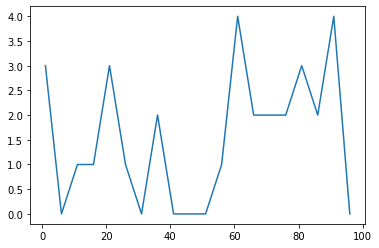

In [77]:
sb.lineplot(time,ps)

In [70]:
pss

array([16, 31, 27, 18, 36, 32, 22, 29,  6, 24, 12, 16, 39, 24,  9,  4,  4,
       14,  6,  0])